### Basic Codes

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE

def load_and_preprocess_mfcc(classCSVPath, label_encoder=None):
    """Loads and preprocesses MFCC data, optionally using an existing label_encoder."""
    mfcc_df = pd.read_csv(classCSVPath)

    if label_encoder is None:
        label_encoder = LabelEncoder()
        label_encoder.fit(mfcc_df["Label"]) #Fit the encoder with all the unique labels.
        mfcc_df["Label"] = label_encoder.transform(mfcc_df["Label"])
    else:
        # Check for new classes and update the encoder if necessary
        new_classes = set(mfcc_df["Label"].unique()) - set(label_encoder.classes_)
        for new_class in new_classes:
            label_encoder.classes_ = np.append(label_encoder.classes_, new_class)
        mfcc_df["Label"] = label_encoder.transform(mfcc_df["Label"])

    mfcc_features = mfcc_df.iloc[:, 3:].values
    labels = mfcc_df["Label"].values

    scaler = StandardScaler()
    mfcc_features = scaler.fit_transform(mfcc_features)
    mfcc_features = mfcc_features.reshape(mfcc_features.shape[0], mfcc_features.shape[1], 1)

    labels_one_hot = to_categorical(labels, num_classes=len(label_encoder.classes_))

    return mfcc_features, labels_one_hot, label_encoder


def load_and_preprocess_spectrogram(spectrogram_paths, label_encoder):
    """Loads and preprocesses spectrogram data."""

    def _load_spectrogram_image(path):  # Inner helper function
        BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../"))
        corrected_path = os.path.abspath(os.path.join(BASE_DIR, path))
        if os.path.exists(corrected_path):
            img = load_img(corrected_path, target_size=(224, 224), color_mode='rgb')
            img = img_to_array(img) / 255.0
            return img, os.path.basename(os.path.dirname(corrected_path))
        else:
            print(f"Warning: Spectrogram not found at {corrected_path}")
            return None, None  # Or raise an exception if you prefer

    images = []
    labels = []
    for path in spectrogram_paths:
        img, label = _load_spectrogram_image(path)
        if img is not None:  # Check if image was loaded successfully
            images.append(img)
            labels.append(label)

    images = np.array(images)
    labels = label_encoder.transform(labels) # Use the same LabelEncoder
    labels_one_hot = to_categorical(labels, num_classes=len(label_encoder.classes_))
    return images, labels_one_hot

def apply_augmentation_and_smote(X_train_spectrogram, y_train_spectrogram, label_encoder):
    """Applies data augmentation and SMOTE to spectrogram data."""
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(X_train_spectrogram)  # Fit BEFORE SMOTE

    unique_classes = np.unique(np.argmax(y_train_spectrogram, axis=1))
    if len(unique_classes) > 1:  # Apply SMOTE only if multiple classes exist
        smote = SMOTE(random_state=37)
        X_train_reshaped = X_train_spectrogram.reshape(X_train_spectrogram.shape[0], -1)  # Reshape for SMOTE
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, np.argmax(y_train_spectrogram, axis=1))
        X_train_resampled = X_train_resampled.reshape(-1, 224, 224, 3)  # Reshape back
        y_train_resampled = to_categorical(y_train_resampled, num_classes=len(label_encoder.classes_))
    else:
        print("Skipping SMOTE: Only one class detected in y_train_spectrogram.")
        X_train_resampled, y_train_resampled = X_train_spectrogram, y_train_spectrogram  # Use original data

    return X_train_resampled, y_train_resampled, datagen


def apply_smote_mfcc(X_train_mfcc, y_train_mfcc, label_encoder):
    """Applies SMOTE to MFCC data."""
    unique_classes = np.unique(np.argmax(y_train_mfcc, axis=1))
    if len(unique_classes) > 1:  # Apply SMOTE only if multiple classes exist
        smote = SMOTE(random_state=37)
        X_train_reshaped = X_train_mfcc.reshape(X_train_mfcc.shape[0], -1)  # Reshape for SMOTE
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, np.argmax(y_train_mfcc, axis=1))
        X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
        y_train_resampled = to_categorical(y_train_resampled, num_classes=len(label_encoder.classes_))
    else:
        print("Skipping SMOTE: Only one class detected in y_train_mfcc.")
        X_train_resampled, y_train_resampled = X_train_mfcc, y_train_mfcc  # Use original data

    return X_train_resampled, y_train_resampled


def SplitDataset(classCSVPath, label_encoder=None):
    """Main function to split and preprocess the dataset."""

    mfcc_features, y_mfcc, label_encoder = load_and_preprocess_mfcc(classCSVPath, label_encoder)
    spectrogram_paths = pd.read_csv(classCSVPath)["Spectrogram_Path"].values

    X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc, train_indices, test_indices = train_test_split(
        mfcc_features, y_mfcc, range(len(y_mfcc)), test_size=0.3, random_state=37, stratify = np.argmax(y_mfcc, axis=1) # Stratify based on original labels
    )

    X_train_spectrogram_paths = spectrogram_paths[train_indices]
    X_test_spectrogram_paths = spectrogram_paths[test_indices]

    X_train_spectrogram, y_train_spectrogram = load_and_preprocess_spectrogram(X_train_spectrogram_paths, label_encoder)
    X_test_spectrogram, y_test_spectrogram = load_and_preprocess_spectrogram(X_test_spectrogram_paths, label_encoder)


    X_train_spectrogram_resampled, y_train_spectrogram_resampled, datagen = apply_augmentation_and_smote(X_train_spectrogram, y_train_spectrogram, label_encoder)
    X_train_mfcc_resampled, y_train_mfcc_resampled = apply_smote_mfcc(X_train_mfcc, y_train_mfcc, label_encoder)

    return X_train_mfcc_resampled, y_train_mfcc_resampled, X_test_mfcc, y_test_mfcc, \
           X_train_spectrogram_resampled, y_train_spectrogram_resampled, X_test_spectrogram, y_test_spectrogram, \
           label_encoder, datagen


In [2]:
# base_audio_path = r"..\Dataset\base_audio_mfcc_features_with_labels.csv"

# X_train_mfcc, y_train_mfcc, X_test_mfcc, y_test_mfcc, X_train_spec, y_train_spec, X_test_spec, y_test_spec, label_encoder, datagen = SplitDataset(base_audio_path)


In [3]:
# # Print sample output
# print(f"Sample MFCC Features Shape: {X_test_mfcc.shape}")  # (samples, timesteps, features)
# print(f"Sample Spectrogram Image Shape: {X_test_spec.shape}")  # (samples, 224, 224, 3)
# print(f"Sample Label One-Hot: {y_test_mfcc[12]}")  # Example label
# print(f"Sample Label One-Hot: {y_test_spec[12]}")  # Example label

### BiLSTM

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import inspect

class IncrementalBiLSTM:
    def __init__(self, input_shape, num_classes, units=128, learning_rate=0.0002, l2_reg=0.001): # Added l2_reg parameter
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.units = units
        self.learning_rate = learning_rate
        self.l2_reg = l2_reg # Store the L2 regularization value
        self.model = self.build_model()
        self.fisher_matrix = None
        self.previous_weights = None

    def build_model(self):
        input_layer = layers.Input(shape=self.input_shape)
        
        bilstm_layer = layers.Bidirectional(layers.LSTM(self.units, return_sequences=False,
                                                        kernel_regularizer=regularizers.l2(self.l2_reg)))(input_layer)

        dense_layer = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg))(bilstm_layer)
        output_layer = layers.Dense(self.num_classes, activation='softmax', kernel_regularizer=regularizers.l2(self.l2_reg))(dense_layer)

        model = models.Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Fix here
        return model


    def train_initial(self, X_train, y_train, epochs=20, batch_size=32, validation_split=0.2):
        y_train_one_hot = to_categorical(y_train, num_classes=self.num_classes)
        history = self.model.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=batch_size,validation_split=validation_split, verbose=1)
        self.calculate_fisher_matrix(X_train, y_train_one_hot)
        self.previous_weights = self.model.get_weights()
        self.plot_training_history(history)
        print(self.fisher_matrix)
    
    def calculate_fisher_matrix(self, X_train, y_train_one_hot):
        fisher_matrices = [np.zeros_like(weight.numpy()) for weight in self.model.trainable_weights]

        for i in range(len(X_train)):
            with tf.GradientTape() as tape:
                predictions = self.model(np.expand_dims(X_train[i], axis=0))
                loss = losses.categorical_crossentropy(np.expand_dims(y_train_one_hot[i], axis=0), predictions)

            gradients = tape.gradient(loss, self.model.trainable_weights)
            for j, grad in enumerate(gradients):
                if grad is not None:  # Ensure grad is not None (e.g., for unused weights)
                    fisher_matrices[j] += np.square(grad.numpy())

        # Normalize Fisher matrix
        fisher_matrices = [fisher / len(X_train) for fisher in fisher_matrices]
        self.fisher_matrix = fisher_matrices


    def train_incremental(self, X_train, y_train, epochs=5, batch_size=32, ewc_lambda=7.0, validation_split=0.2):
        y_train_one_hot = to_categorical(y_train, num_classes=self.num_classes)
        optimizer = optimizers.Adam(learning_rate=self.learning_rate)

        # Split data for validation
        train_size = int(len(X_train) * (1 - validation_split))
        X_train_train, X_val = X_train[:train_size], X_train[train_size:]
        y_train_train, y_val = y_train_one_hot[:train_size], y_train_one_hot[train_size:]

        history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

        for epoch in range(epochs):
            for batch_start in range(0, len(X_train_train), batch_size):
                batch_end = batch_start + batch_size
                batch_X = X_train_train[batch_start:batch_end]
                batch_y = y_train_train[batch_start:batch_end]

                with tf.GradientTape() as tape:
                    predictions = self.model(batch_X, training=True)
                    loss = losses.categorical_crossentropy(batch_y, predictions)

                    # EWC regularization
                    if self.fisher_matrix and self.previous_weights:
                        ewc_loss = 0.0
                        for i, weight in enumerate(self.model.trainable_weights):
                            # Skip output layer weights in EWC calculation
                            if weight.shape != self.previous_weights[i].shape:
                                continue
                            ewc_loss += ewc_lambda * tf.reduce_sum(self.fisher_matrix[i] * tf.square(weight - self.previous_weights[i]))
                        loss += ewc_loss

                gradients = tape.gradient(loss, self.model.trainable_weights)
                optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))

            # Evaluate on training and validation sets
            train_loss, train_acc = self.model.evaluate(X_train_train, y_train_train, verbose=0)
            val_loss, val_acc = self.model.evaluate(X_val, y_val, verbose=0)

            history['loss'].append(train_loss)
            history['accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)

            print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Val_Loss: {val_loss:.4f}, Val_Accuracy: {val_acc:.4f}")

        self.previous_weights = self.model.get_weights()
        self.calculate_fisher_matrix(X_train, y_train_one_hot)
        self.ewc_plot_training_history(history)
        print("Changed fisher matrix: ", self.fisher_matrix)

    def add_new_label(self, X_train, y_train, X_old=None, y_old=None, epochs=5, batch_size=16, ewc_lambda=5.0):
        """Adds a new label to the model incrementally, updating the output layer."""
        
        print(f"🔵 Adding new label: Current num_classes = {self.num_classes}, Incrementing by 1.")
        self.num_classes += 1  # Increment class count

        # Store existing weights
        old_weights = {layer.name: layer.get_weights() for layer in self.model.layers}
        print("✅ Old Weights Stored Successfully!")

        # Remove old output layer
        old_output_layer = self.model.layers[-1]
        old_output_weights = old_output_layer.get_weights()
        print(f"✅ Old Output Layer Weights Retrieved\nOld Output Layer Weights Shape: {[w.shape for w in old_output_weights]}")

        # Create a new output layer with one additional neuron
        new_output_layer = layers.Dense(self.num_classes, activation='softmax', 
                                        kernel_regularizer=regularizers.l2(self.l2_reg), 
                                        name='new_output_layer')

        print(f"✅ Created New Output Layer with {self.num_classes} Classes")

        # Rebuild model with modified architecture
        input_tensor = self.model.input
        x = input_tensor
        for i, layer in enumerate(self.model.layers[1:-1]):  # Exclude last (output) layer
            print(f"🔄 Applying layer {i}: {layer.name} ({layer.__class__.__name__})")
            try:
                x = layer(x)
            except Exception as e:
                print(f"🚨 Error at layer {i}: {layer.name} - {e}")
                return  # Stop execution if an error occurs

        output_tensor = new_output_layer(x)  # Attach the new output layer
        self.model = models.Model(inputs=input_tensor, outputs=output_tensor)
        print("✅ Model Architecture Updated Successfully!")

        # Transfer weights to new layers (except output layer)
        for layer in self.model.layers[:-1]:
            if layer.name in old_weights:
                layer.set_weights(old_weights[layer.name])
                print(f"✅ Weights Transferred to Layer: {layer.name}")

        # Initialize the new output layer with old weights + random values for the new class
        new_output_weights = []
        for i, old_w in enumerate(old_output_weights):
            print(f"🔍 Processing Old Weight {i}: Shape {old_w.shape}")
            
            if old_w.ndim == 2:  # Weight matrix
                new_w = np.concatenate([old_w, np.random.normal(0, 0.01, (old_w.shape[0], 1))], axis=1)
            elif old_w.ndim == 1:  # Bias vector
                new_w = np.concatenate([old_w, np.zeros((1,))], axis=0)
            else:
                print(f"🚨 Unexpected Shape in Weights: {old_w.shape}")
                return  # Stop execution if an error occurs
            
            print(f"✅ New Weight {i} Shape: {new_w.shape}")
            new_output_weights.append(new_w)

        print(f"🔍 Final New Output Weights Shape: {[w.shape for w in new_output_weights]}")
        
        # Set new weights for the output layer
        try:
            new_output_layer.set_weights(new_output_weights)
            print("✅ New Output Layer Weights Set Successfully!")
        except ValueError as e:
            print(f"🚨 Weight Assignment Error: {e}")
            return

        # Recompile model
        self.learning_rate=0.00035
        self.model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate),
                        loss=losses.CategoricalCrossentropy(),
                        metrics=['accuracy'])
        print("✅ Model Compiled Successfully!")

        # Adjust new labels
        y_train_adjusted = y_train + (self.num_classes - 1 - np.max(y_train))
        print(f"🔄 Adjusted Labels: min={y_train_adjusted.min()}, max={y_train_adjusted.max()}")

        # Merge old and new data
        if X_old is not None and y_old is not None:
            X_combined = np.concatenate((X_train, X_old), axis=0)
            y_combined = np.concatenate((y_train_adjusted, y_old), axis=0)
            print(f"✅ Combined Data: X shape {X_combined.shape}, y shape {y_combined.shape}")
        else:
            X_combined = X_train
            y_combined = y_train_adjusted
            print(f"✅ Using Only New Data: X shape {X_combined.shape}, y shape {y_combined.shape}")

        # Train the model incrementally
        self.train_incremental(X_combined, y_combined, epochs, batch_size, ewc_lambda)
        print("🚀 Incremental Training Complete!")




    def plot_training_history(self, history):
        if history is None:
            return
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history.history:
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.legend()
        plt.title('Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title('Loss')
        plt.show()

    def evaluate_model(self, X_test, y_test, label_encoder): #updated function to accept label_encoder
        y_pred_probs = self.model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
        print(classification_report(y_test, y_pred, target_names=label_encoder.inverse_transform(np.unique(y_test))))
        print(f"Test Accuracy: {np.mean(y_pred == y_test)}")

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.inverse_transform(np.unique(y_test)), yticklabels=label_encoder.inverse_transform(np.unique(y_test)))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    def ewc_plot_training_history(self, history):
        if history is None:
            return
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history:
            plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.legend()
        plt.title('Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(history['loss'], label='Train Loss')
        if 'val_loss' in history:
            plt.plot(history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title('Loss')
        plt.show()


In [6]:
import pickle

initial_csv_path  = r"..\Dataset\base_audio_mfcc_features_with_labels.csv"
X_train_mfcc, y_train_mfcc, X_test_mfcc, y_test_mfcc, \
X_train_spectrogram, y_train_spectrogram, X_test_spectrogram, y_test_spectrogram, \
label_encoder, datagen = SplitDataset(initial_csv_path)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.5140 - loss: 1.4492 - val_accuracy: 0.7206 - val_loss: 1.1704
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6739 - loss: 1.0683 - val_accuracy: 0.7206 - val_loss: 0.8486
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7386 - loss: 0.7230 - val_accuracy: 0.8235 - val_loss: 0.7137
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8816 - loss: 0.6504 - val_accuracy: 0.8676 - val_loss: 0.5845
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9086 - loss: 0.5073 - val_accuracy: 0.8971 - val_loss: 0.5335
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9476 - loss: 0.3480 - val_accuracy: 0.9265 - val_loss: 0.4280
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9265 - loss: 0.3590 - val_accuracy: 0.9265 - val_loss: 0.3980
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9634 - loss: 0.2308 - val_accuracy: 0.9412 - val_loss: 0.3665


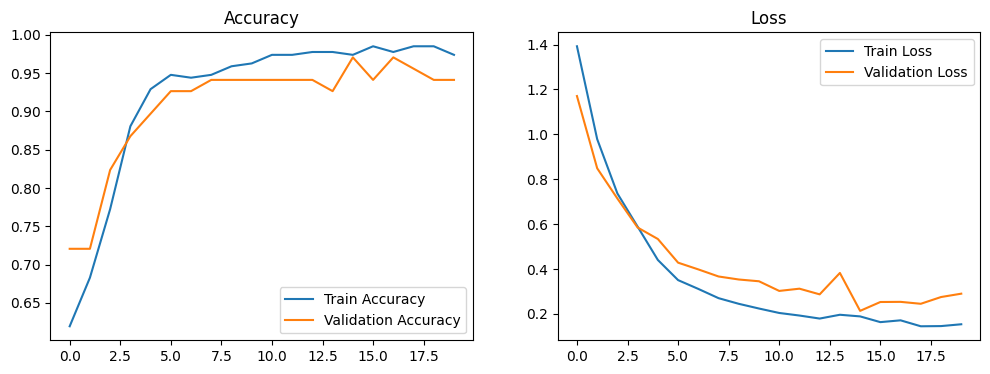

[array([[6.54668038e-05, 6.76036434e-05, 7.70922285e-04, 1.49199215e-04,
        1.18155622e-04, 9.17032012e-05, 2.42162987e-05, 5.09295205e-04,
        2.49905884e-03, 3.62414758e-05, 5.76983257e-05, 2.00209673e-04,
        3.81286431e-04, 2.84434325e-04, 1.72263499e-05, 4.95927015e-05,
        4.04072693e-04, 4.92077670e-04, 1.49074767e-04, 1.50326538e-04,
        7.27676263e-04, 3.85685300e-04, 5.14938962e-04, 2.07760022e-04,
        2.16599627e-04, 5.44092327e-05, 1.51575616e-04, 2.92573910e-04,
        8.87993025e-04, 1.50315813e-04, 2.75850005e-04, 3.91367867e-05,
        8.93523742e-04, 6.31809118e-04, 6.59062236e-04, 9.62787017e-04,
        2.26726028e-04, 1.31331544e-04, 4.81872048e-05, 8.33952508e-05,
        1.17315569e-04, 4.23398669e-05, 8.91376461e-04, 4.05551800e-05,
        7.16997136e-04, 2.86820810e-04, 1.01129677e-04, 1.92429696e-04,
        1.39279015e-04, 3.01067175e-05, 6.37002377e-05, 7.65520439e-04,
        1.73050939e-04, 8.79369472e-05, 4.43312638e-05, 8.52458

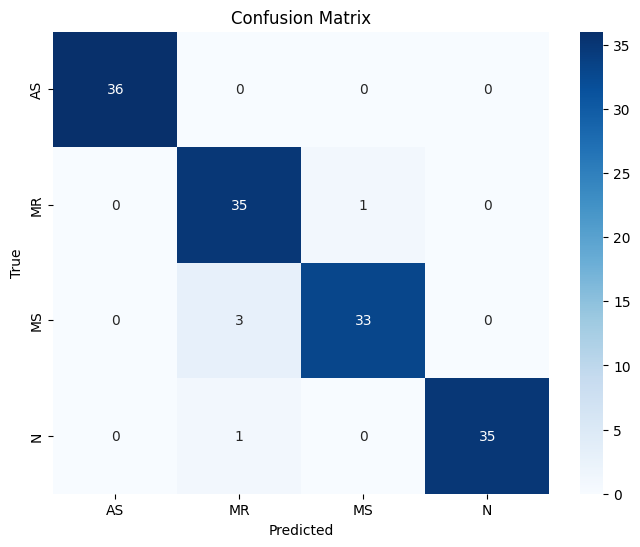

In [7]:
input_shape = (X_train_mfcc.shape[1], 1)  # (time_steps, features)
num_classes = y_train_mfcc.shape[1]

model = IncrementalBiLSTM(input_shape, num_classes, units=128,l2_reg=0.0005)
model.train_initial(X_train_mfcc, np.argmax(y_train_mfcc, axis=1))
model.evaluate_model(X_test_mfcc, np.argmax(y_test_mfcc, axis=1), label_encoder)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)




['AS' 'MR' 'MS' 'N']
Epoch 1/5, Loss: 1.2293, Accuracy: 0.7313, Val_Loss: 0.5929, Val_Accuracy: 0.8261
Epoch 2/5, Loss: 0.9809, Accuracy: 0.7363, Val_Loss: 0.7637, Val_Accuracy: 0.6087
Epoch 3/5, Loss: 0.7951, Accuracy: 0.8159, Val_Loss: 0.5591, Val_Accuracy: 0.7826
Epoch 4/5, Loss: 0.6610, Accuracy: 0.8756, Val_Loss: 0.3157, Val_Accuracy: 0.9130
Epoch 5/5, Loss: 0.5964, Accuracy: 0.9055, Val_Loss: 0.2677, Val_Accuracy: 0.9130


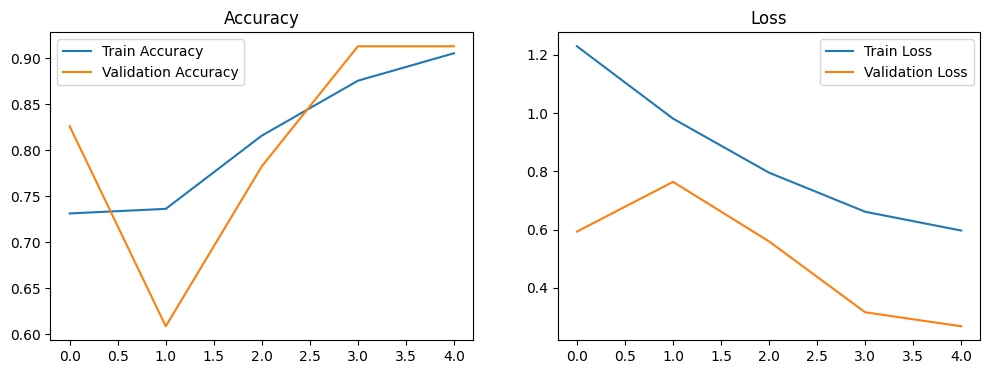

Changed fisher matrix:  [array([[5.27843440e-05, 2.16297602e-04, 2.29227386e-04, 4.83292126e-04,
        6.22106716e-04, 2.37664281e-04, 2.92833720e-04, 9.45198874e-04,
        6.13347918e-04, 2.34763993e-05, 6.81164674e-05, 6.51339433e-05,
        7.31039210e-04, 4.37714072e-04, 4.09836830e-05, 3.91283364e-04,
        3.57347744e-04, 1.34556904e-04, 1.35657974e-04, 6.77088174e-05,
        2.13478153e-04, 7.48355000e-04, 3.34026932e-04, 6.66038599e-04,
        3.39269551e-04, 7.56705704e-04, 1.72763554e-04, 1.50447988e-04,
        6.64003950e-04, 4.83519194e-04, 3.15949612e-04, 6.21507425e-05,
        2.11113202e-03, 4.10630571e-04, 2.47322780e-04, 1.20786356e-03,
        2.04903656e-04, 1.60186508e-04, 2.56572202e-05, 9.84307917e-05,
        1.89819999e-04, 3.09167866e-04, 3.25011177e-04, 5.26601099e-04,
        2.92657496e-04, 1.13970693e-03, 3.67345026e-04, 4.49533181e-05,
        4.40828706e-04, 8.83231332e-05, 3.12924385e-04, 2.17543726e-04,
        8.45996256e-04, 8.77075945e-04,

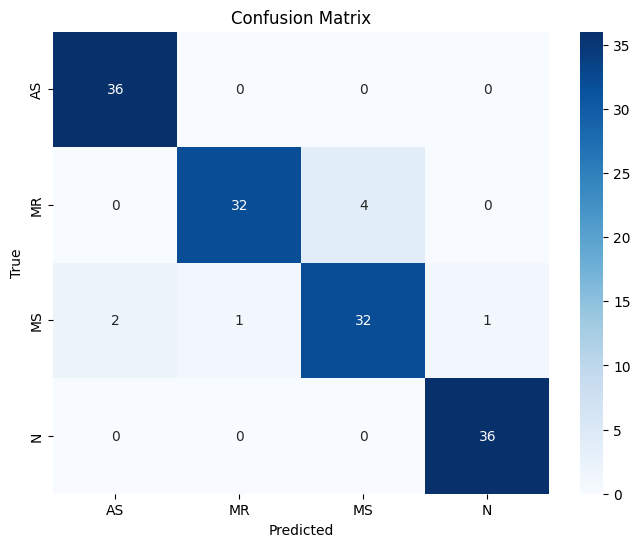

In [8]:
with open("label_encoder.pkl", "rb") as f:
    loaded_label_encoder = pickle.load(f)

incremental_csv_path = r"..\Dataset\inc_audio_mfcc_features_with_labels.csv"

inc_train_x_mfcc, inc_train_y_mfcc, inc_test_mfcc, _, _, _, _, _, upd_label_encoder, _ = SplitDataset(incremental_csv_path, loaded_label_encoder)
print(upd_label_encoder.classes_)
model.train_incremental(inc_train_x_mfcc, np.argmax(inc_train_y_mfcc, axis=1), validation_split=0.1) #use incremental train function.
model.evaluate_model(X_test_mfcc, np.argmax(y_test_mfcc, axis=1), upd_label_encoder)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(upd_label_encoder, f)

Skipping SMOTE: Only one class detected in y_train_spectrogram.
Skipping SMOTE: Only one class detected in y_train_mfcc.
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
Class Mapping in Label Encoder:
AS: 0
MR: 1
MS: 2
N: 3
MVP: 4
🔹 Combined X_train shape: (151, 13, 1)
🔹 Combined y_train shape: (151, 5)
🔵 Adding new label: Current num_classes = 4, Incrementing by 1.
✅ Old Weights Stored Successfully!
✅ Old Output Layer Weights Retrieved
Old Output Layer Weights Shape: [(256, 4), (4,)]
✅ Created New Output Layer with 5 Classes
🔄 Applying layer 0: bidirectional (Bidirectional)
🔄 Applying layer 1: dense (Dense)
✅ Model Architecture Updated Successfully!
✅ Weights Transferred to Layer: input_layer
✅ Weights Transferred to Layer: bidirectional
✅ Weights Transferred to Layer: dense
🔍 Processing Old Weight 0: Shape (256, 4)
✅ New Weight 0 Shape: (256, 5)
🔍 Processing Old Weight 1: Shape (4,)
✅ New Weight 1 Shape: (5,)
🔍 Final New Output Weights Shape: [(256, 5), (5,)]
✅ New Output Layer We

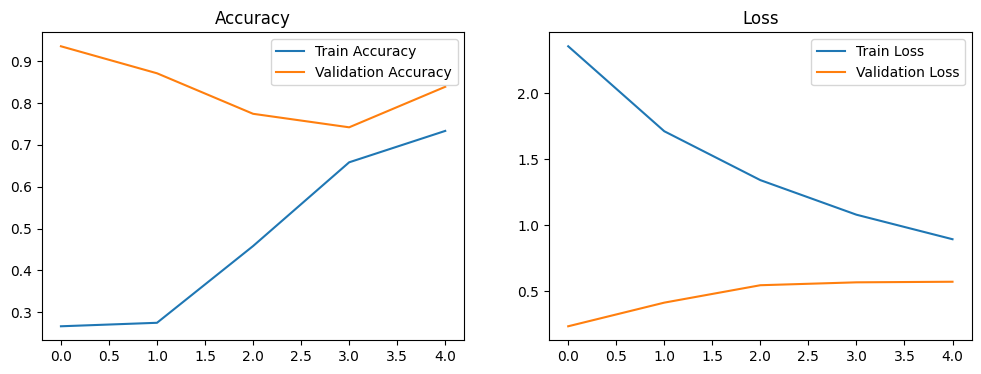

Changed fisher matrix:  [array([[3.90577770e-05, 2.04432163e-05, 7.00916426e-05, 6.52051895e-05,
        4.04382336e-05, 8.34534003e-05, 3.34527722e-05, 7.12541078e-05,
        6.72958122e-05, 1.20613768e-05, 4.29775719e-05, 3.13898636e-05,
        4.27938176e-05, 1.72659347e-04, 2.32990697e-05, 7.59641480e-05,
        3.71809510e-05, 5.75710983e-05, 1.41682503e-05, 2.77744039e-05,
        8.37962507e-05, 5.22027694e-05, 3.24680041e-05, 1.54620531e-04,
        9.84296566e-05, 4.40941658e-05, 4.66558085e-05, 2.95969967e-05,
        4.44769576e-05, 2.19445574e-04, 1.71507534e-04, 1.56246660e-05,
        1.71683016e-04, 3.64287334e-05, 3.96862779e-05, 5.11607141e-05,
        3.92461880e-05, 1.66509490e-05, 1.97524150e-05, 2.91019114e-05,
        1.47599523e-04, 3.45976841e-05, 8.20775458e-05, 7.01519530e-05,
        3.38920727e-05, 3.53132091e-05, 4.34212852e-05, 2.07612611e-05,
        2.91378856e-05, 4.67357822e-05, 4.35105430e-05, 9.15966884e-05,
        1.29737135e-04, 1.20176017e-04,

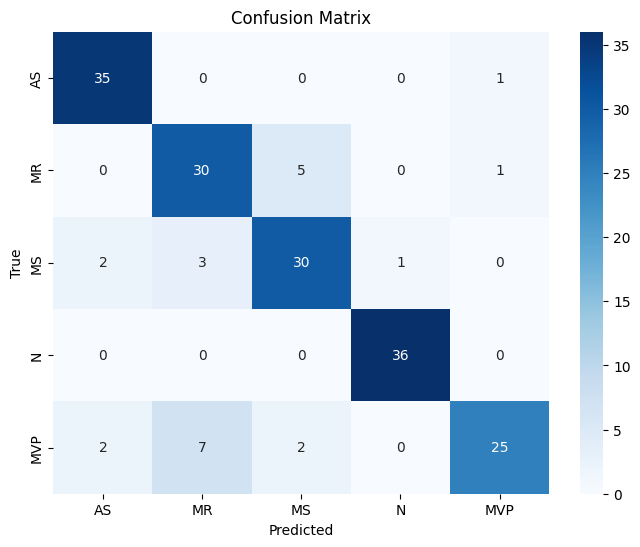

In [9]:
with open("label_encoder.pkl", "rb") as f:
    loaded_label_encoder = pickle.load(f)

mvp_csv_path = r"..\Dataset\continuous_audio_mfcc_features_with_labels.csv"
mvp_train_x_mfcc, mvp_train_y_mfcc, mvp_test_x_mfcc, mvp_test_y_mfcc, _, _, _, _, upd_label_encoder, _ = SplitDataset(mvp_csv_path, loaded_label_encoder)

def sample_data(X, y, sample_ratio=0.3):
    """Randomly selects a percentage of the data."""
    sample_size = int(len(X) * sample_ratio)  # Calculate 20% of the data
    indices = np.random.choice(len(X), sample_size, replace=False)  # Randomly select indices
    return X[indices], y[indices]  # Return sampled data

old_x_train_mfcc,old_y_train_mfcc,old_x_test_mfcc, old_y_test_mfcc, _,_,_,_,upd_label_encoder, _ = SplitDataset(initial_csv_path, upd_label_encoder)
print(old_y_train_mfcc[3])
old_x_sample, old_y_sample = sample_data(old_x_train_mfcc, old_y_train_mfcc, sample_ratio=0.2)

print(old_y_sample[3])
print(old_y_test_mfcc[12])

print("Class Mapping in Label Encoder:")
for class_name, encoded_value in zip(upd_label_encoder.classes_, range(len(upd_label_encoder.classes_))):
    print(f"{class_name}: {encoded_value}")

combined_x_train = np.concatenate((mvp_train_x_mfcc, old_x_sample), axis=0)
combined_y_train = np.concatenate((mvp_train_y_mfcc, old_y_sample), axis=0)

# Debug: Print shapes before training
print(f"🔹 Combined X_train shape: {combined_x_train.shape}")
print(f"🔹 Combined y_train shape: {combined_y_train.shape}")

# Use the combined dataset for incremental learning
model.add_new_label(combined_x_train, np.argmax(combined_y_train, axis=1)) 

# Ensure all arrays are NumPy arrays
print(old_y_test_mfcc[12])
X_combined_test = np.concatenate((old_x_test_mfcc, mvp_test_x_mfcc), axis=0)
y_combined_test = np.concatenate((old_y_test_mfcc, mvp_test_y_mfcc), axis=0)

# Evaluate the model with the combined test set
model.evaluate_model(X_combined_test, np.argmax(y_combined_test, axis=1), upd_label_encoder)

# model.evaluate_model(mvp_test_x_mfcc, np.argmax(mvp_test_y_mfcc, axis=1), upd_label_encoder)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(upd_label_encoder, f)

In [10]:
# print(old_y_test_mfcc[12])
# print(mvp_test_y_mfcc[13])
# X_combined_test = np.concatenate((old_x_test_mfcc, mvp_test_x_mfcc), axis=0)
# y_combined_test = np.concatenate((old_y_test_mfcc, mvp_test_y_mfcc), axis=0)

# # Evaluate the model with the combined test set
# model.evaluate_model(X_combined_test, np.argmax(y_combined_test, axis=1), upd_label_encoder)

# # model.evaluate_model(mvp_test_x_mfcc, np.argmax(mvp_test_y_mfcc, axis=1), upd_label_encoder)

# with open("label_encoder.pkl", "wb") as f:
#     pickle.dump(upd_label_encoder, f)